---

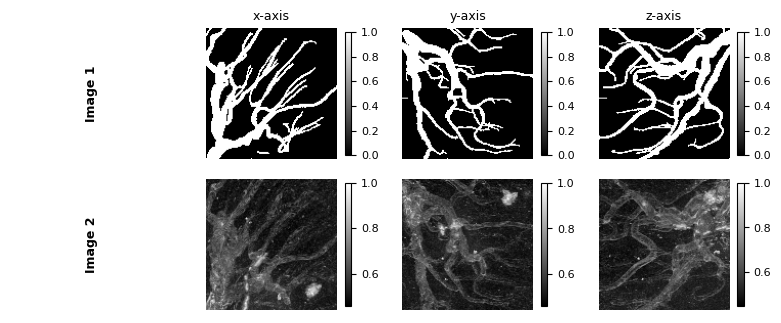

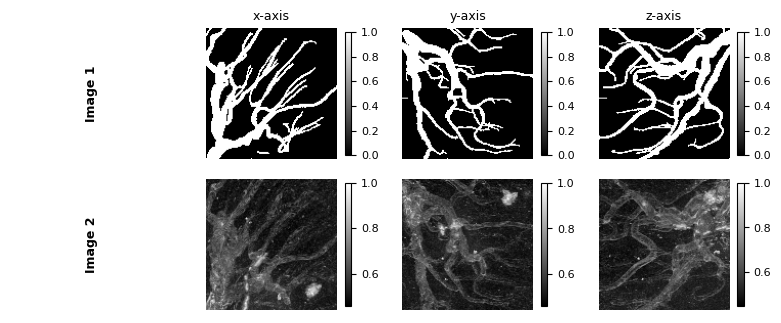

In [1]:
from core.io.loader import Loader
from core.utils.viewer import Viewer
from core.io.saver import Saver
# label = Loader('').load_data('3d/split_30/labels/label_14.npy', crop=True, target_shape=(128, 128, 128))[:, :, 50]
# image = Loader('').load_data('3d/split_30/images/image_14.npy', crop=True, target_shape=(128, 128, 128))[:, :, 50]
# Viewer().display_images([label, image])

label = Loader('').load_data('3d/split_30/labels/label_14.npy', crop=True, target_shape=(128, 128, 128))
image = Loader('').load_data('3d/split_30/images/image_14.npy', crop=True, target_shape=(128, 128, 128))
Viewer().display_mip([label, image])

# figure = Viewer().display_slices(image)
# Saver(output_dir="results").save_anim(figure, "slice_image_14")

---

In [ ]:
from core.processing.pipeline import Pipeline
from core.config.setup import SetupConfig
from core.config.experiment import ExperimentConfig, LoadingConfig, MethodsConfig, ProcessingConfig, HessianConfig, EnhancementConfig, SegmentationConfig, Experiment
from core.config.builder import ConfigBuilder

setup_config = SetupConfig(
    name="pipeline",
    input_dir="2d",
    output_dir="pipeline",
    log_file="pipline",
    debug_mode=False,
    plot_mode=False,
    save_mode=True,
)

loading_config = LoadingConfig(
    normalize=True,
    crop=False,
    target_shape=None,
    raw_file="images/image_0.png",
    gt_file="labels/label_0.png",
)

methods_config = MethodsConfig(
    derivator="default",
    enhancer='frangi',
    segmenter='thresholding',
)

processing_config = ProcessingConfig(
    use_gpu=False, # implementation not validated yet
    normalize=True, # normalization [0, 1] after enhacement
    parallelize=False, # for volumetric data, not used if 2d data
    show_progress=False, # verbose mode
    overlap_size=10, # size in voxel, not necessary if parallelize=False
    chunk_size=(128, 128, 128), # size in voxel, not necessary if parallelize=False
)

enhancement_config = EnhancementConfig(
    black_ridges=False, # vessel contrast
    scales=[2, 4, 6, 8, 10], # scale for multi-scale enhancement
    alpha=0.5, # plateness
    beta=0.5, # blobness
    gamma=None, # brightness
    skimage=False, # use frangi function from skimage, useful for checks
    hessian_function=None, # not necessary, selected from methods_config
    hessian_params=None, # not necessary, added directly in the pipeline process
)

hessian_config = HessianConfig(
    mode='reflect', # mode to deal with borders of the image
    cval=0.0, # value if mode='constant'
)

segmentation_config = SegmentationConfig(
    threshold=0.5, # threshold for binary segmentation, if None and ground_truth defined in loading_config the threshold is optimized
)

experiment_config = ExperimentConfig(
    loading=loading_config,
    methods=methods_config,
    processing=processing_config,
    hessian=hessian_config,
    enhancement=enhancement_config,
    segmentation=segmentation_config,
)

# OR

# experiment_config = ConfigBuilder(
#     config_source="pipeline.yaml",
#     config_class=ExperimentConfig,
# )

pipeline = Pipeline(setup_config)

experiment = pipeline.run(experiment_config)

data_enhanced = experiment.data_enhanced
data_segmented = experiment.data_segmented  
config = experiment.config 

0.035224564
0.4979914309755883


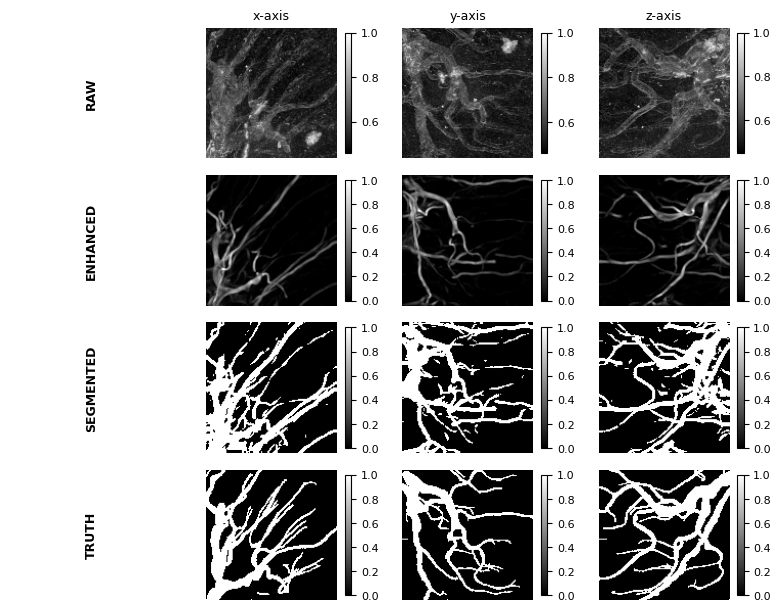

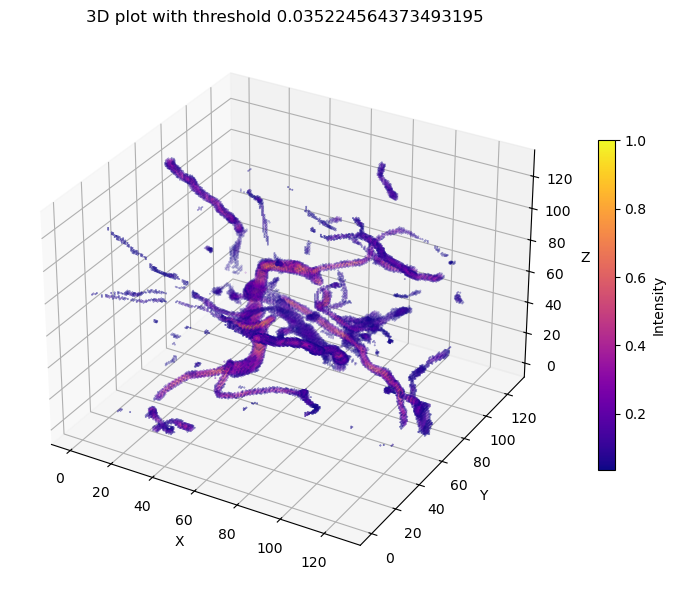

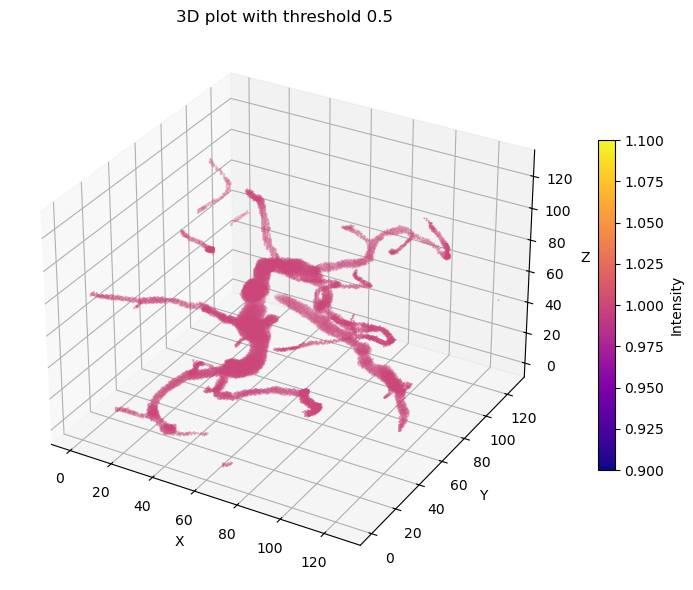

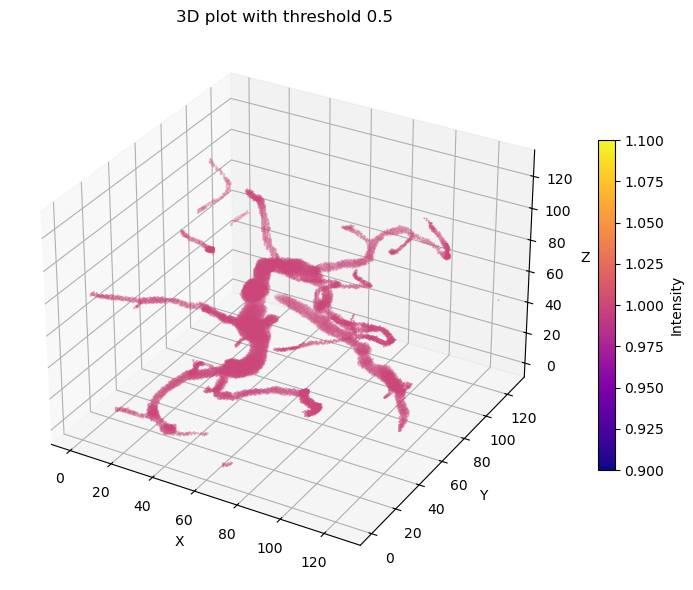

In [ ]:
from core.processing.processor import Processor
from core.processing.derivator import Derivator
from core.processing.enhancer import Enhancer
from core.processing.segmenter import Segmenter
from core.experiments.analytics.hessian import AnalyticsHessian
from core.config.experiment import ProcessingConfig, HessianConfig, EnhancementConfig, SegmentationConfig, MethodsConfig
from core.experiments.metrics import mcc, dice, roc, pr
from core.io.loader import Loader
from core.utils.viewer import Viewer
import numpy as np


processing_config = ProcessingConfig(
    use_gpu=False,
    normalize=True,
    parallelize=False,
    chunk_size=(128, 128, 128),
    overlap_size=10,
)
derivator = Derivator(False)
enhancer = Enhancer(False)

hessian_config = HessianConfig(mode='reflect', cval=0.0)
enhancement_config = EnhancementConfig(
    scales=[2, 4, 6, 8, 10],
    alpha=0.5,
    beta=0.5,
    gamma=15,
    black_ridges=True,
    skimage=False,
)
segmentation_config = SegmentationConfig(0.05)
methods = MethodsConfig(
    derivator='gaussian',
    enhancer='frangi',
    segmenter='thresholding',
)


processor = Processor(processing_config)

enhanced, segmented, threshold = processor.process_data(image, hessian_config, enhancement_config, segmentation_config, methods, label)

print(threshold)
print(mcc(segmented.ravel(), label.ravel()))

# Viewer().display_images([image, enhanced, segmented, label])
Viewer().display_mip([image, enhanced, segmented, label], ["RAW", "ENHANCED", "SEGMENTED", "TRUTH"])
Viewer().display_volume(enhanced, threshold)
Viewer().display_volume(label, 0.5)



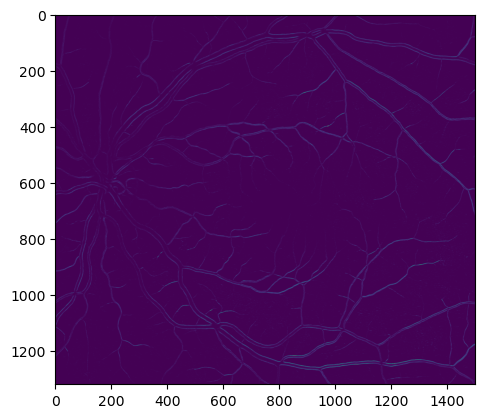

In [47]:
from skimage.filters import frangi 
import matplotlib.pyplot as plt
image = loader.load_data('test/test.jpg')
enhanced = frangi(image, range(1, 10, 1), alpha=0.5, beta=0.5, gamma=5, black_ridges=False)

plt.imshow(enhanced)


-0.012502509036412077 0.25867778736679437


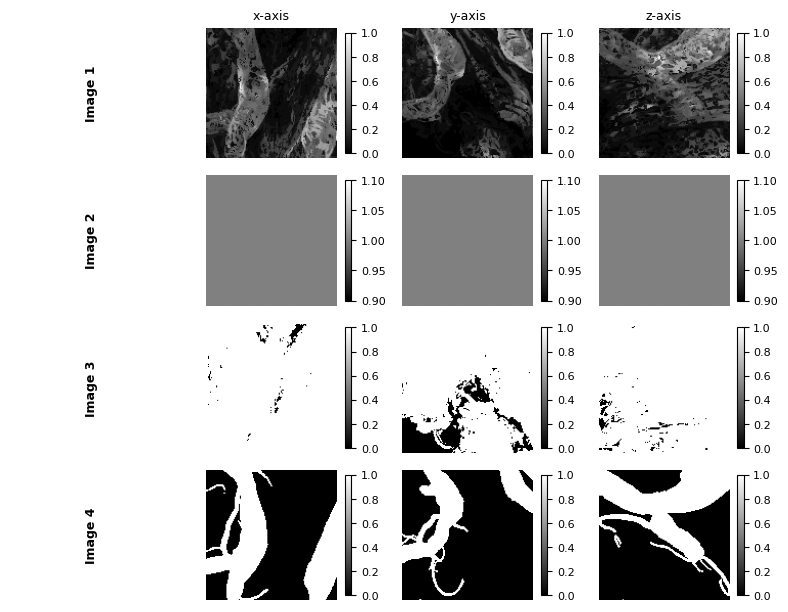

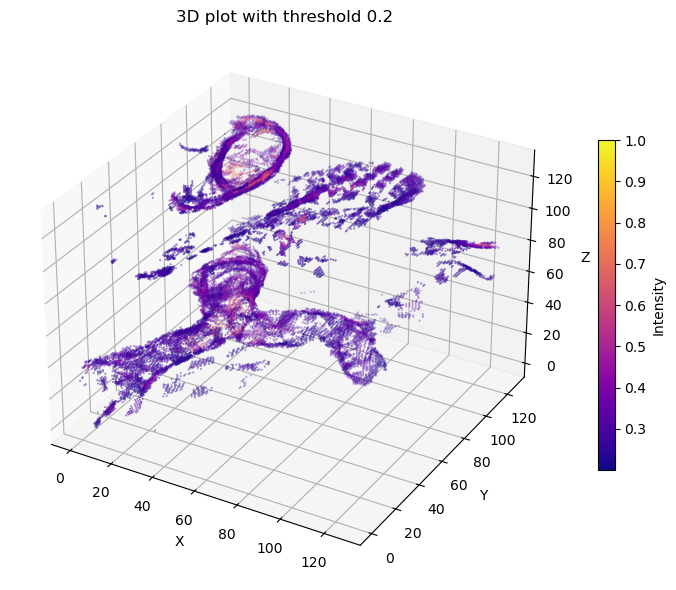

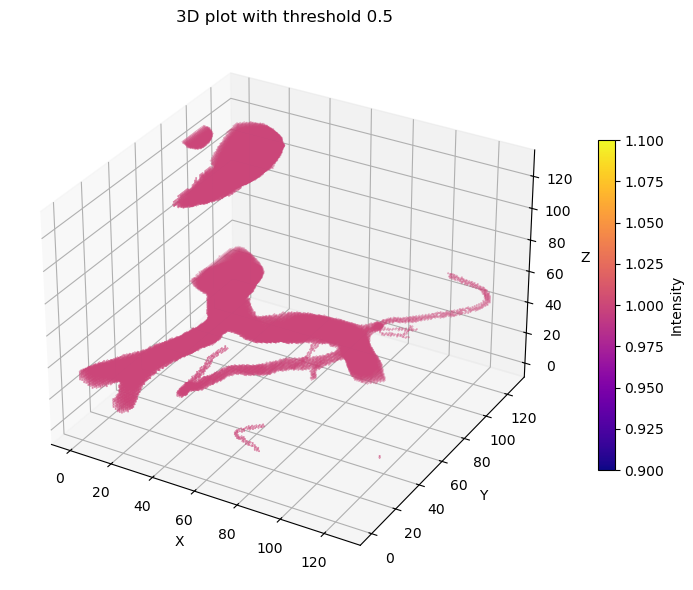

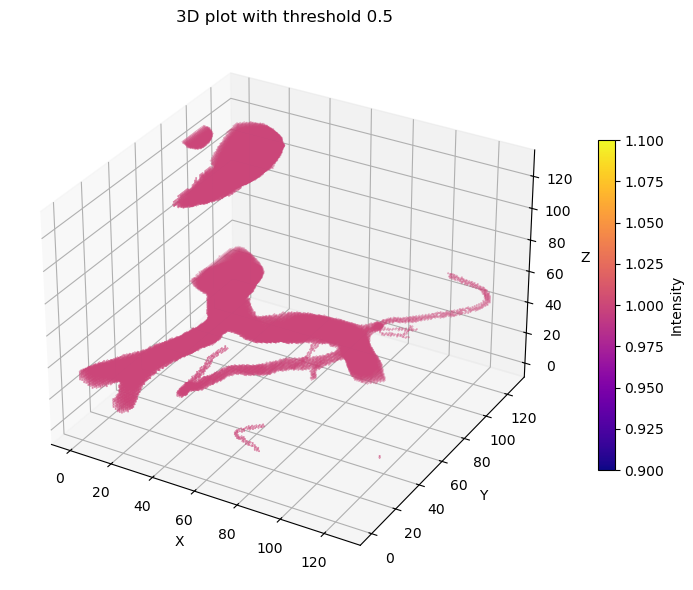

In [32]:
import numpy as np
from numpy import ndarray
from typing import Literal, Callable, Optional, Tuple
from sklearn.metrics import precision_recall_curve
from core.utils.helpers import normalize_data
import matplotlib.pyplot as plt

def thresholding(
    data: ndarray, 
    threshold: float = 0.5, 
    ground_truth: Optional[ndarray] = None
) -> Tuple[ndarray, float]:
    data_normalized = normalize_data(data)
    if ground_truth is not None:
        gt_normalized = normalize_data(ground_truth)
        precision, recall, thresholds = precision_recall_curve(gt_normalized.ravel(), data_normalized.ravel())
        f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
        threshold = thresholds[np.argmax(f1_scores)]
    elif threshold is None:
        threshold = 0.5
    data_segmented = (data_normalized > threshold).astype(np.uint8)
    return data_segmented, threshold


segmented_test, threshold_test = thresholding(enhanced, 0.2)
print(mcc(segmented_test, label), mcc(segmented, label))
Viewer().display_mip([enhanced, 1-segmented_test, segmented, label])
Viewer().display_volume(volume=enhanced, threshold=0.2)
Viewer().display_volume(volume=label, threshold=0.5)

MCC: 0.6472496275710985 - DICE: 0.6858876943588257 - ROC: 0.8870632332604304 - PR: 0.6811168615853634


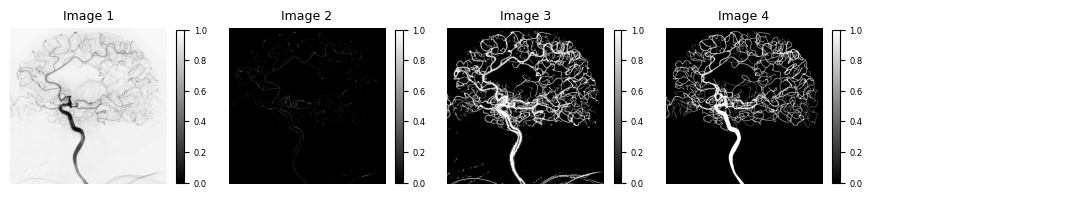

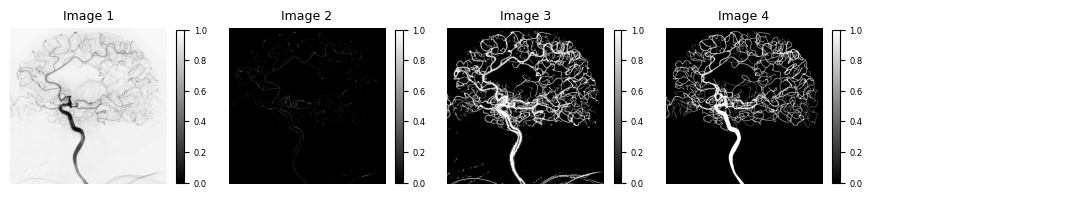

In [ ]:
from core.processing.processor import Processor
from core.processing.derivator import Derivator
from core.processing.enhancer import Enhancer
from core.processing.segmenter import Segmenter
from core.config.experiment import ProcessingConfig, HessianConfig, EnhancementConfig, SegmentationConfig, MethodsConfig
from core.experiments.metrics import mcc, dice, roc, pr
from core.io.loader import Loader
from core.utils.viewer import Viewer
import numpy as np


processing_config = ProcessingConfig(
    use_gpu=False,
    normalize=True,
    parallelize=False,
    chunk_size=(128, 128, 128),
    overlap_size=10,
)
derivator = Derivator(False)
enhancer = Enhancer(False)

hessian_config = HessianConfig(mode='reflect', cval=0.0)
enhancement_config = EnhancementConfig(
    scales=[1, 2, 3, 4, 5, 6, 7, 8],
    alpha=0.5,
    beta=0.5,
    gamma=20,
    black_ridges=True,
    skimage=False,
)
segmentation_config = SegmentationConfig(None)
methods = MethodsConfig(
    derivator='farid',
    enhancer='frangi',
    segmenter='thresholding',
)

processor = Processor(processing_config)
loader = Loader('')
image = loader.load_data('test/2d/images/image_40.png')
label = loader.load_data('test/2d/labels/label_40.png')

enhanced, segmented, threshold = processor.process_data(image, hessian_config, enhancement_config, segmentation_config, methods, label)


mcc_score = mcc(segmented, label)
dice_score = dice(segmented, label)
roc_score = roc(enhanced, label)
pr_score = pr(enhanced, label)

print(f'MCC: {mcc_score} - DICE: {dice_score} - ROC: {roc_score} - PR: {pr_score}')

Viewer().display_images([image, enhanced, segmented, label])


In [ ]:
segmenter = Segmenter()

segmented_test, threshold_test = segmenter.thresholding(data=enhanced, threshold=0.2)
print(mcc(segmented_test, label))
print(threshold)
Viewer().display_mip([enhanced, segmented_test, segmented, label])
print(enhanced.shape)
Viewer().display_volume(volume=enhanced, threshold=0.02)
Viewer().display_volume(volume=label, threshold=0.5)

In [ ]:
from core.processing.processor import Processor
from core.processing.derivator import Derivator
from core.processing.enhancer import Enhancer
from core.processing.segmenter import Segmenter
from core.config.experiment import ProcessingConfig, HessianConfig, EnhancementConfig, SegmentationConfig, MethodsConfig
from core.experiments.metrics import mcc, dice, roc, pr
from core.io.loader import Loader
from core.utils.viewer import Viewer
import numpy as np


processing_config = ProcessingConfig(
    use_gpu=False,
    normalize=True,
    parallelize=True,
    chunk_size=(128, 128, 128),
    overlap_size=10,
)
derivator = Derivator(False)
enhancer = Enhancer(False)

hessian_config = HessianConfig(mode='reflect', cval=0.0)
enhancement_config = EnhancementConfig(
    scales=[2, 3, 4, 5, 6, 7, 8],
    alpha=0.5,
    beta=0.5,
    gamma=20,
    skimage=True,
    black_ridges=False,
)
segmentation_config = SegmentationConfig(None)
methods = MethodsConfig(
    derivator='farid',
    enhancer='frangi',
    segmenter='thresholding',
)

processor = Processor(processing_config)
loader = Loader('')
image = loader.load_data('3d/kidney_images.npy', crop=True, target_shape=(512, 512, 512))
label = loader.load_data('3d/kidney_labels.npy', crop=True, target_shape=(512, 512, 512))

enhanced, segmented, threshold = processor.process_data(image, hessian_config, enhancement_config, segmentation_config, methods, label)


mcc_score = mcc(segmented, label)
dice_score = dice(segmented, label)
roc_score = roc(enhanced, label)
pr_score = pr(enhanced, label)

print(f'MCC: {mcc_score} - DICE: {dice_score} - ROC: {roc_score} - PR: {pr_score}')

[########################################] | 100% Completed | 20m 35ss
MCC: -0.011878976369555936 - DICE: 4.42364216723945e-05 - ROC: 0.4974884782581689 - PR: 0.028103042295114757


---

In [ ]:
from core.processing.pipeline import Pipeline
from core.config.builder import ConfigBuilder
from core.config.setup import SetupConfig
from core.config.experiment import ExperimentConfig, LoadingConfig, MethodsConfig, EnhancementConfig, HessianConfig, SegmentationConfig, ProcessingConfig

pipeline = Pipeline(SetupConfig(
    name="pipeline",
    input_dir="test",
    output_dir="pipeline",
    log_file="pipline",
    debug_mode=False,
    plot_mode=False,
    save_mode=True,
)) 

loading_config = LoadingConfig(
    normalize=True,
    crop=False,
    target_shape=(32, 32, 32),
    raw_file="images/image_0.png",
    gt_file="labels/label_0.png",
)

methods_config = MethodsConfig(
    derivator="default",
    enhancer='frangi',
    segmenter='thresholding',
)

enhacement_config = EnhancementConfig(
    alpha=0.5,
    beta=0.5,
    gamma=10,
    scales=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    black_ridges=True,
    skimage=False,
)

processing_config = ProcessingConfig(
    normalize=True,
    parallelize=False,
    chunk_size=(32, 32, 32),
    overlap_size=10,
)

hessian_config = HessianConfig(
    mode='reflect',
    cval=0.0
)

segmentation_config = SegmentationConfig(
   threshold=None
)

experiment_config = ExperimentConfig(
    loading=loading_config,
    methods=methods_config,
    processing=processing_config,
    hessian=hessian_config,
    enhancement=enhacement_config,
    segmentation=segmentation_config,
)

14:34:06 - [INFO]: [INIT] Pipeline initialized


In [17]:
experiment = pipeline.run(config=experiment_config)

14:34:09 - [INFO]: [START] Pipeline execution
14:34:09 - [INFO]: [LOAD] Data image_0.png loaded | shape=(800, 800).
14:34:09 - [INFO]: [LOAD] Data label_0.png loaded | shape=(800, 800).
14:34:09 - [DEBUG]: [CALL] "enhance_data"
                       - args:   [<core.pipeline.enhancer.Enhancer object at 0x0000021996E5BB00>]
                       - kwargs: { data=ndarray(shape=(800, 800), dtype=float32), method='frangi', processing_params=ProcessingConfig(normalize=True, parallelize=False, chunk_size=(32, 32, 32), overlap_size=10), enhancement_params=EnhancementConfig(alpha=0.5, beta=0.5, gamma=10, scales=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], scales_number=None, scales_range=None, black_ridges=True, hessian_function=<bound method Derivator.default of <core.pipeline.derivator.Derivator object at 0x0000021996E5B320>>, skimage=False), hessian_params=HessianConfig(mode='reflect', cval=0.0) }
14:34:09 - [INFO]: Sequential processing in progress...
14:34:09 - [DEBUG]: [CALL] "frangi"
            

In [13]:
from core.io.loader import Loader

loader = Loader("test")

image_raw = loader.load_data('images/image_0.png')
ground_truth = loader.load_data('labels/label_0.png')

In [ ]:
from core.loader import Loader
from src.pipeline import Pipeline
from core.config import SetupConfig
from src.enhancer import Enhancer

SetupConfig(
        name="test_benchmark",
        log_file="test",
        input_dir="data/test",
        output_dir=str("out"),
        debug_mode=True,
        plot_mode=True,
        save_mode=False,
    )

raw = Loader('data/test').load_data('test_raw.nii', crop=False)
enhanced = Enhancer().frangi(
    image=raw, 
    hessian_params={'mode': 'reflect','cval': 0,'use_gaussian_derivatives': True},
    skimage=True,
    scales=range(1, 10, 2)
)


12:34:32 - [INFO]: [LOAD] Data test_raw.nii loaded with shape (195, 155, 150) and normalized.
12:34:32 - [INFO]: The enhancement is done with frangi function from skimage.


12:42:42 - [INFO]: [LOAD] Data test_gt.nii loaded with shape (195, 155, 150) and normalized.


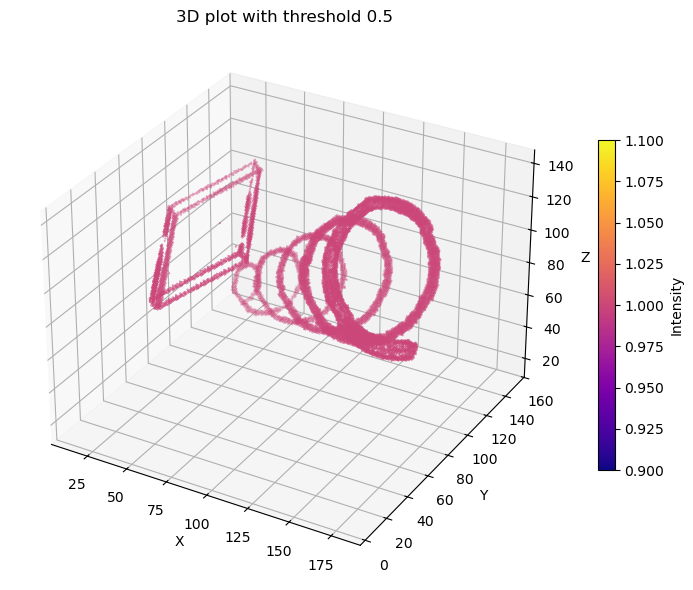

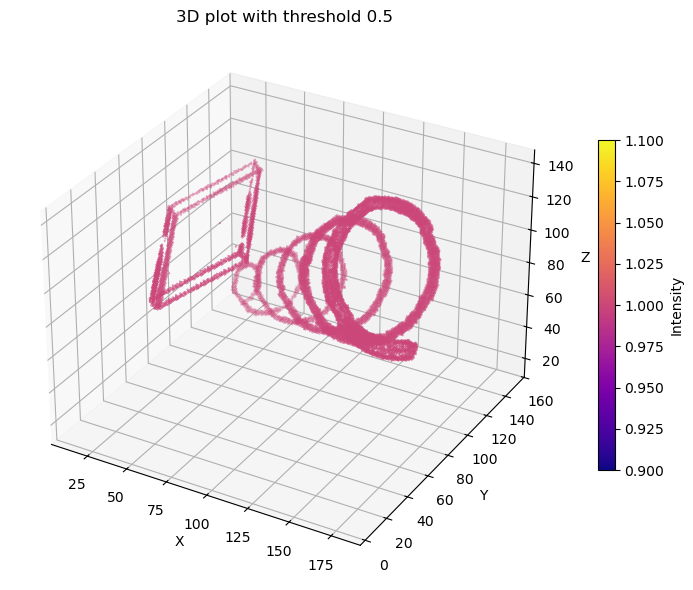

In [42]:
data = Loader('data/test').load_data('test_gt.nii', crop=False)
Viewer().display_volume(data, 0.5)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from benchmark.computational_time import scale_size_influence, volume_size_influence, chunk_number_influence

scale_size_influence(32, (1, 10), [2, 4], 'frangi', 2)
volume_size_influence(np.array([32, 64]), 2, (1, 10), 'frangi', 2)
chunk_number_influence([32, 64], 2, (1, 10), 'frangi', [2, 4])

[########################################] | 100% Completed | 2.18 sms
[########################################] | 100% Completed | 4.10 sms
08:35:38 - [INFO]: ======================================== RESUME ========================================

08:35:38 - [INFO]: 
Influence du nombre d'échelle sur le temps d'exécution du réhaussement

08:35:38 - [INFO]: Scales number:    [2, 4]
08:35:38 - [INFO]: Times sequential: [0.4265462999974261, 0.526276800002961]
08:35:38 - [INFO]: Times parallel:   [6.470020900000236, 4.167211899999529]
08:35:38 - [INFO]: 
|   Scales (num) |   Time sequential (s) |   Time parallel (s) |
|----------------|-----------------------|---------------------|
|              2 |                 0.427 |               6.470 |
|              4 |                 0.526 |               4.167 |
08:35:38 - [INFO]: ========================================================================================

[########################################] | 100% Completed | 2.52 sms


([32, 64],
 [2, 4],
 [[16, 8], [32, 16]],
 [[2.6615614000038477, 2.6376338000045507],
  [3.5068361000012374, 23.19713519999641]])